<a href="https://colab.research.google.com/github/MHzNug/Capstone-Project/blob/main/Model%20Klasifikasi%20Padi/Capstone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# ===📦 Paket bawaan===
import os
import random
import shutil

# ===📊 Data dan visualisasi===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===🖼️ Pemrosesan gambar===
from PIL import Image
import cv2

# ===🤖 TensorFlow & Keras===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras import Input
from keras.layers import TFSMLayer

# ===🧪 Utilities===
from sklearn.model_selection import train_test_split

# ===🌐 Kaggle Hub===
import kagglehub

In [2]:
rice_path = kagglehub.dataset_download("loki4514/rice-leaf-diseases-detection")
corn_path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
potato_path = kagglehub.dataset_download("rizwan123456789/potato-disease-leaf-datasetpld")
cassava_path = kagglehub.dataset_download("nirmalsankalana/cassava-leaf-disease-classification")
tomato_path = kagglehub.dataset_download("kaustubhb999/tomatoleaf")

print("Rice dataset path:", rice_path)
print("Corn dataset path:", corn_path)
print("Potato dataset path:", potato_path)
print("Cassava dataset path:", cassava_path)
print("Tomato dataset path:", tomato_path)

100%|██████████| 161M/161M [00:07<00:00, 22.9MB/s]

Extracting files...


100%|██████████| 37.4M/37.4M [00:03<00:00, 12.1MB/s]

Extracting files...


100%|██████████| 2.39G/2.39G [02:01<00:00, 21.0MB/s]

Extracting files...


100%|██████████| 179M/179M [00:08<00:00, 21.5MB/s]

Extracting files...


Rice dataset path: /kaggle/input/rice-leaf-diseases-detection
Corn dataset path: /root/.cache/kagglehub/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/versions/1
Potato dataset path: /root/.cache/kagglehub/datasets/rizwan123456789/potato-disease-leaf-datasetpld/versions/1
Cassava dataset path: /root/.cache/kagglehub/datasets/nirmalsankalana/cassava-leaf-disease-classification/versions/2
Tomato dataset path: /root/.cache/kagglehub/datasets/kaustubhb999/tomatoleaf/versions/1


In [3]:
combined_path = 'combined_dataset'
os.makedirs(combined_path, exist_ok=True)

In [4]:
def copy_images_with_crop_prefix(src_dir, dst_root, crop_prefix="", use_crop_prefix=True):
    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if os.path.isdir(class_path):
            if use_crop_prefix:
                dst_class = f"{crop_prefix}___{class_name.replace(' ', '_')}"
            else:
                dst_class = class_name.replace(' ', '_')

            dst_class_path = os.path.join(dst_root, dst_class)
            os.makedirs(dst_class_path, exist_ok=True)

            for img_name in os.listdir(class_path):
                src_img = os.path.join(class_path, img_name)
                dst_img = os.path.join(dst_class_path, img_name)

                # Rename if file already exists
                if os.path.exists(dst_img):
                    base, ext = os.path.splitext(img_name)
                    i = 1
                    while os.path.exists(dst_img):
                        new_name = f"{base}_{i}{ext}"
                        dst_img = os.path.join(dst_class_path, new_name)
                        i += 1

                shutil.copy(src_img, dst_img)


# Rice dataset
copy_images_with_crop_prefix(os.path.join(rice_path, 'Rice_Leaf_Diease/Rice_Leaf_Diease/train'), combined_path, "Rice")

# Corn dataset
copy_images_with_crop_prefix(os.path.join(corn_path, 'data'), combined_path, "Corn")

# Potato dataset
copy_images_with_crop_prefix(os.path.join(potato_path, 'PLD_3_Classes_256/Training'), combined_path, 'Potato')

# Cassava dataset
copy_images_with_crop_prefix(os.path.join(cassava_path, 'data'), combined_path, use_crop_prefix=False)

# Tomato dataset
copy_images_with_crop_prefix(os.path.join(tomato_path, 'tomato/train'), combined_path, use_crop_prefix=False)

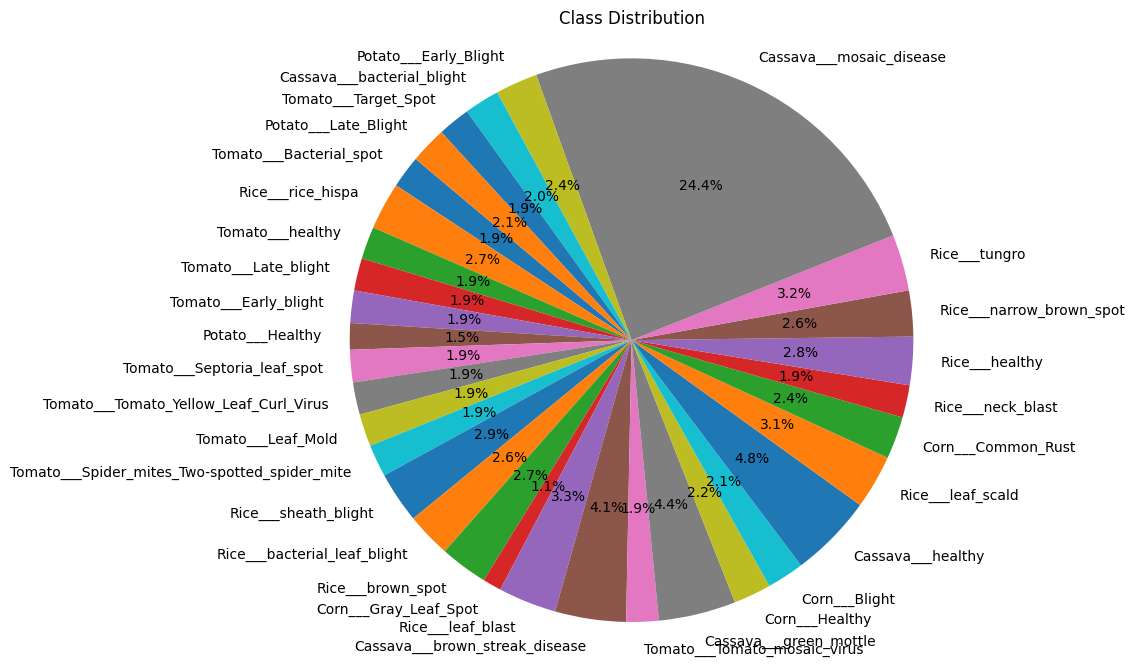

In [5]:
# Ambil nama-nama kelas (subfolder)
class_names = [d for d in os.listdir(combined_path) if os.path.isdir(os.path.join(combined_path, d))]

# Hitung jumlah gambar per kelas
class_counts = []
for class_name in class_names:
    class_path = os.path.join(combined_path, class_name)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    class_counts.append(len(image_files))

# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

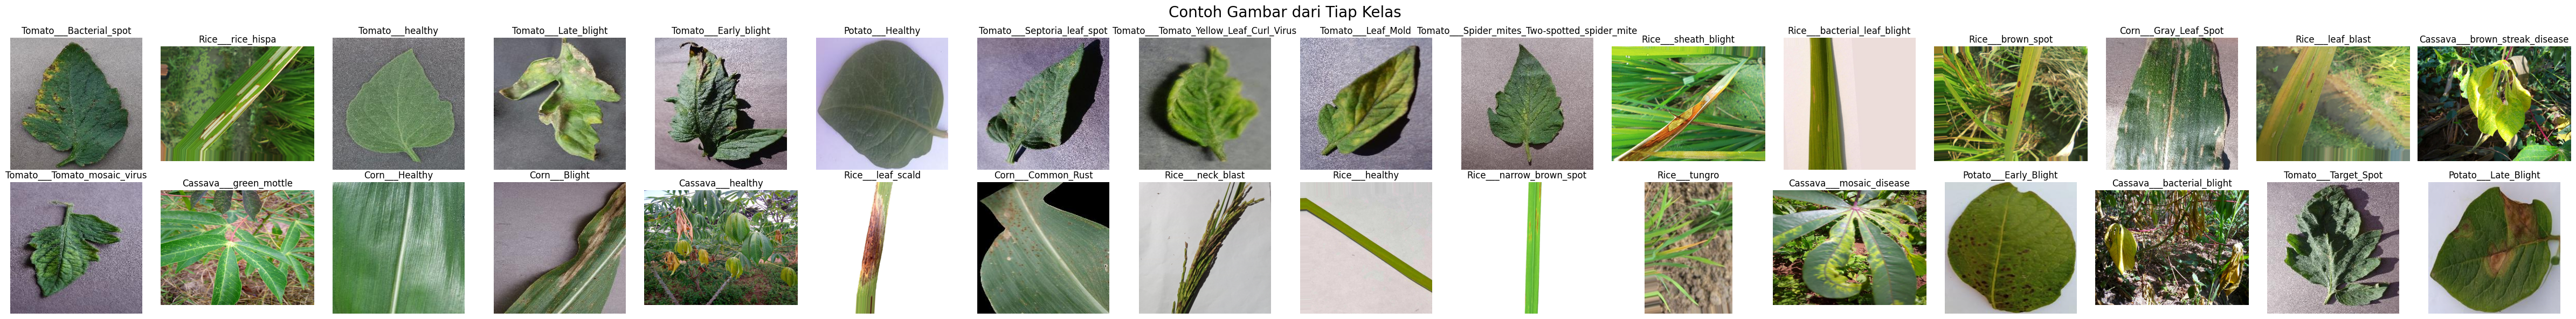

In [6]:
n_classes = len(class_names)

# Ukuran grid subplot
n_rows = 2
n_cols = int(np.ceil(n_classes / n_rows))

# Buat subplot
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()  # ubah ke array 1 dimensi agar mudah di-loop

for i, ax in enumerate(axs):
    if i >= n_classes:
        ax.axis('off')  # kosongkan sisa plot jika subplot lebih banyak dari kelas
        continue

    class_name = class_names[i]
    class_path = os.path.join(combined_path, class_name)

    # Ambil semua path gambar yang valid
    image_paths = [
        os.path.join(class_path, img)
        for img in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, img)) and img.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    # Tampilkan gambar acak dari kelas ini
    if image_paths:
        img = cv2.imread(random.choice(image_paths))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(class_name)
    ax.axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas", fontsize=20)
plt.tight_layout()
plt.show()

In [7]:
def split_dataset(
    src_folder,
    dest_folder,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Total rasio harus 1.0"

    random.seed(seed)

    class_names = [d for d in os.listdir(src_folder) if os.path.isdir(os.path.join(src_folder, d))]

    for class_name in class_names:
        src_class_path = os.path.join(src_folder, class_name)
        images = [
            f for f in os.listdir(src_class_path)
            if os.path.isfile(os.path.join(src_class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, split_images in splits.items():
            dest_class_path = os.path.join(dest_folder, split_name, class_name)
            os.makedirs(dest_class_path, exist_ok=True)

            for img_name in split_images:
                src_img_path = os.path.join(src_class_path, img_name)
                dst_img_path = os.path.join(dest_class_path, img_name)

                shutil.copy2(src_img_path, dst_img_path)

    print(f"Selesai split dataset ke dalam folder: {dest_folder}")

# Jalankan split
split_dataset(
    src_folder='combined_dataset',
    dest_folder='split_dataset',
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
)

Selesai split dataset ke dalam folder: split_dataset


In [10]:
from sklearn.utils import class_weight

def compute_class_weights(
    folder_path,
    split='train'
):
    """
    Menghitung class weights menggunakan sklearn berdasarkan jumlah sampel di folder_path/<split>.
    Args:
        folder_path: folder utama dengan subfolder per split ('train','val','test')
        split: salah satu dari 'train','val','test'
    Returns:
        dict mapping class_name to weight
    """
    split_folder = os.path.join(folder_path, split)
    class_names = sorted([
        d for d in os.listdir(split_folder)
        if os.path.isdir(os.path.join(split_folder, d))
    ])

    # Kumpulkan label y berdasarkan folder nama kelas
    y = []
    for cls in class_names:
        cls_path = os.path.join(split_folder, cls)
        images = [
            f for f in os.listdir(cls_path)
            if os.path.isfile(os.path.join(cls_path, f))
        ]
        y.extend([cls] * len(images))

    y = np.array(y)
    classes = np.array(class_names)

    # Compute weights
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y
    )

    class_weights = dict(zip(class_names, weights))
    print(f"Class weights for split '{split}':")
    for cls, w in class_weights.items():
        print(f"  {cls}: {w:.4f}")
    return class_weights


weights = compute_class_weights(
        folder_path='split_dataset',
        split='train'
    )

Class weights for split 'train':
  Cassava___bacterial_blight: 1.5491
  Cassava___brown_streak_disease: 0.7688
  Cassava___green_mottle: 0.7055
  Cassava___healthy: 0.6531
  Cassava___mosaic_disease: 0.1279
  Corn___Blight: 1.4696
  Corn___Common_Rust: 1.2894
  Corn___Gray_Leaf_Spot: 2.9327
  Corn___Healthy: 1.4490
  Potato___Early_Blight: 1.2919
  Potato___Healthy: 2.0646
  Potato___Late_Blight: 1.4874
  Rice___bacterial_leaf_blight: 1.2149
  Rice___brown_spot: 1.1369
  Rice___healthy: 1.1293
  Rice___leaf_blast: 0.9348
  Rice___leaf_scald: 1.0076
  Rice___narrow_brown_spot: 1.1892
  Rice___neck_blast: 1.6827
  Rice___rice_hispa: 1.1525
  Rice___sheath_blight: 1.0667
  Rice___tungro: 0.9670
  Tomato___Bacterial_spot: 1.6827
  Tomato___Early_blight: 1.6827
  Tomato___Late_blight: 1.6827
  Tomato___Leaf_Mold: 1.6827
  Tomato___Septoria_leaf_spot: 1.6827
  Tomato___Spider_mites_Two-spotted_spider_mite: 1.6827
  Tomato___Target_Spot: 1.6827
  Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1.6827

In [53]:
split_dir = os.path.join(os.getcwd(), 'split_dataset')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_dir, 'train'),
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(split_dir, 'test'),
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'val'),
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical'
)

Found 43076 images belonging to 32 classes.
Found 5406 images belonging to 32 classes.
Found 5377 images belonging to 32 classes.


In [54]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, acc_threshold=0.95, val_acc_threshold=0.95):
        super(StopTrainingAtAccuracy, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.acc_threshold and val_acc >= self.val_acc_threshold:
                print(f"\n Target tercapai! Akurasi dan val_akurasi >= {self.acc_threshold * 100:.0f}%")
                self.model.stop_training = True

In [58]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
callback = [
    StopTrainingAtAccuracy(),
    ModelCheckpoint('model_checkpoint.keras', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
]

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callback,
    verbose=1,
    class_weight=weights
)

Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.4827 - loss: 1.7439
Epoch 1: val_loss improved from inf to 1.51460, saving model to model_checkpoint.keras
674/674 ━━━━━━━━━━━━━━━━━━━━ 350s 510ms/step - accuracy: 0.4829 - loss: 1.7434 - val_accuracy: 0.5551 - val_loss: 1.5146
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6701 - loss: 0.9875
Epoch 2: val_loss did not improve from 1.51460
674/674 ━━━━━━━━━━━━━━━━━━━━ 336s 499ms/step - accuracy: 0.6701 - loss: 0.9874 - val_accuracy: 0.4465 - val_loss: 2.6223
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7238 - loss: 0.7917
Epoch 3: val_loss improved from 1.51460 to 1.29669, saving model to model_checkpoint.keras
674/674 ━━━━━━━━━━━━━━━━━━━━ 336s 498ms/step - accuracy: 0.7238 - loss: 0.7917 - val_accuracy: 0.6234 - val_loss: 1.2967
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7486 - loss: 0.7111
Epoch 4: val_loss improved from 1.29669 to 0.83919, saving m

KeyboardInterrupt: 

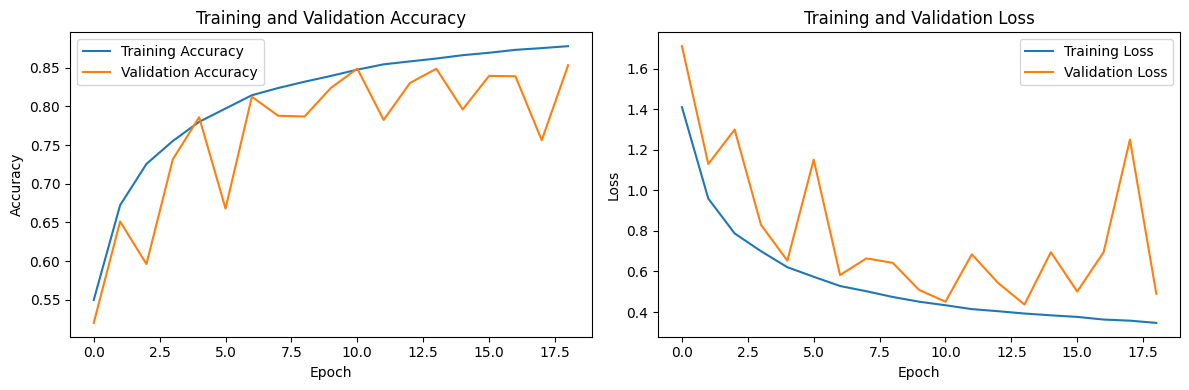

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import classification_report

# Dapatkan label asli
true_labels = test_gen.classes

# Dapatkan label prediksi
pred_probs = model.predict(test_gen, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# Label nama kelas
class_names = list(test_gen.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))

169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step
Classification Report:

                                               precision    recall  f1-score   support

                   Cassava___bacterial_blight       0.00      0.00      0.00       110
               Cassava___brown_streak_disease       0.03      0.04      0.03       220
                       Cassava___green_mottle       0.04      0.05      0.05       240
                            Cassava___healthy       0.05      0.04      0.04       259
                     Cassava___mosaic_disease       0.24      0.25      0.24      1317
                                Corn___Blight       0.03      0.03      0.03       116
                           Corn___Common_Rust       0.04      0.04      0.04       132
                        Corn___Gray_Leaf_Spot       0.00      0.00      0.00        58
                               Corn___Healthy       0.03      0.03      0.03       117
                        Potato___Early_Blight       0.03     

In [17]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - accuracy: 0.8616 - loss: 0.4490
Test Loss: 0.4631, Test Accuracy: 0.8600


In [18]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [19]:
model.save("/content/my_model.keras")

In [20]:
model.save("/content/my_model.h5")

In [21]:
!tensorflowjs_converter \
    --input_format=keras \
    my_model.h5 \
    tfjs_model/

2025-05-27 17:30:53.170246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748367053.192540   68567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748367053.199254   68567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [22]:
from google.colab import files

!zip -r tfjs_model.zip tfjs_model
files.download("tfjs_model.zip")

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# SavedModel (untuk TFLite & TFJS)
model.export('/content//saved_model')

# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/content//saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)
Captures:
  135910555870864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555871632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555874320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555871248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555873552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555874512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555875664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555876048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135910555874896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13591055

In [24]:
!zip -r saved_model.zip saved_model
files.download("saved_model.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 71%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
Keys dari hasil prediksi: dict_keys(['output_0'])


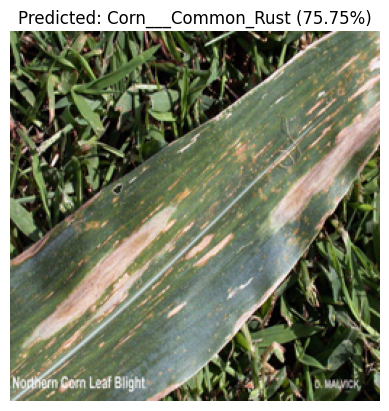

In [49]:
# --- Load gambar test ---
import requests
from io import BytesIO

# URL gambar
img_url = 'https://extension.umn.edu/sites/extension.umn.edu/files/styles/large/public/northernleafblight2_600px.jpg?itok=bdY09BXo'

# Unduh gambar dari URL
response = requests.get(img_url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img = img.resize((255, 255))  # Sesuai target size Anda

# Konversi ke array dan normalisasi
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# --- Load SavedModel sebagai Layer ---
saved_model_path = "/content/saved_model"
model_loaded = TFSMLayer(saved_model_path, call_endpoint="serving_default")

# --- Bungkus dalam Model baru ---
input_layer = Input(shape=img_array.shape[1:])
output_layer = model_loaded(input_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# --- Inference ---
pred_dict = model.predict(img_array)

# --- Cek key dari dict ---
print("Keys dari hasil prediksi:", pred_dict.keys())  # dict_keys(['output_0'])

# Ambil nilai array prediksi dari dict
pred = list(pred_dict.values())[0]

# --- Ambil kelas dan confidence ---
predicted_class = list(train_gen.class_indices.keys())[np.argmax(pred)]
confidence = np.max(pred) * 100

# --- Tampilkan Gambar + Prediksi ---
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.show()
